In [1]:
using Pkg
Pkg.activate("MLJ_environment", shared=true)
using StatsBase: corkendall
using DataFrames
using Queryverse
using VegaLite
using MLJ




# House Price Prediction

## Objective

The objective is to build a regression model which predicts houseprice from several housing variables.

## Data Description 

Area and Prices are quantitative variables measured in square-feet and dollars respectively.  Garage, FirePlace and Baths refers to the number of this items in a specific house.  City is a qualitative variable indicating one of 3 different cities.  All remaining variable indicate the presence (1) of absence (0) of that feature.  

In [2]:
# Load the data and show a preview
houseprice = Queryverse.load("/home/chigball/Data/houseprice.csv") |> DataFrame
describe(houseprice)

16×7 DataFrame
 Row │ variable      mean          min    median   max    nmissing  eltype   
     │ Symbol        Float64       Int64  Float64  Int64  Int64     DataType 
─────┼───────────────────────────────────────────────────────────────────────
   1 │ Area            124.93          1    125.0    249         0  Int64
   2 │ Garage            2.00129       1      2.0      3         0  Int64
   3 │ FirePlace         2.0034        0      2.0      4         0  Int64
   4 │ Baths             2.99807       1      3.0      5         0  Int64
   5 │ WhiteMarble       0.332992      0      0.0      1         0  Int64
   6 │ BlackMarble       0.33269       0      0.0      1         0  Int64
   7 │ IndianMarble      0.334318      0      0.0      1         0  Int64
   8 │ Floors            0.499386      0      0.0      1         0  Int64
   9 │ City              2.00094       1      2.0      3         0  Int64
  10 │ Solar             0.498694      0      0.0      1         0  Int64
  11 │ Electric          0.50065       0      1.0      1         0  Int64
  12 │ Fiber             0.500468      0      1.0      1         0  Int64
  13 │ GlassDoors        0.49987       0      0.0      1         0  Int64
  14 │ SwimingPool       0.500436      0      1.0      1         0  Int64
  15 │ Garden            0.501646      0      1.0      1         0  Int64
  16 │ Prices        42050.1        7725  41850.0  77975         0  Int64

## Data Exploraton 

Data was manipulated to investigate one of three things:

1. Distribution of house price
2. How area affects the average house price
3. What house price variable contribute to house price

In [3]:
# Dicts for code manipulation 
D1 = Dict("001" => "Indian", "010" => "Black", "100" => "White")
D2 = Dict(0 => "No", 1 => "Yes")

# Manipulate data for data exploration
houseprice_ex = houseprice |> 
@mutate(MarbleType = string(_.WhiteMarble) * string(_.BlackMarble) * string(_.IndianMarble)) |> 
@mutate(MarbleType = D1[_.MarbleType]) |>
@mutate(Floors = D2[_.Floors]) |> # Floors
@mutate(Solar = D2[_.Solar]) |> # Solar
@mutate(Electric = D2[_.Electric]) |> # Electric
@mutate(Fiber = D2[_.Fiber]) |> # Fiber
@mutate(GlassDoors = D2[_.GlassDoors]) |> # GlassDoors
@mutate(SwimingPool = D2[_.SwimingPool]) |> # SwimingPool
@mutate(Garden = D2[_.Garden]) |> # Garden
@select(1:4, 17, 8:16) |> DataFrame

# Code creates expressions for aggregation and plotting of dependent variable 	 against average price 
function aggprice(v::Symbol, x::String)
:(
houseprice_ex |> 
@groupby(_.$v) |> 
@map({$v = key(_), Avg_Price = mean(_.Prices)}) |> 
@orderby(_.$v) |> 
@vlplot(
mark = :bar,
x = $x,
y = {"Avg_Price:q", title = "Average Price"}
)  
)
end

# Data plots of dependent variables vs price
Garage = eval(aggprice(:Garage, "Garage:n")) # Garage y
FirePlace = eval(aggprice(:FirePlace, "FirePlace:n")) # FirePlace y
Baths = eval(aggprice(:Baths, "Baths:n")) # Baths y
MarbleType = eval(aggprice(:MarbleType, "MarbleType:n")) # MarbleType yy
Floors = eval(aggprice(:Floors, "Floors:n")) # Floors yy
City = eval(aggprice(:City, "City:n")) # City y
Solar = eval(aggprice(:Solar, "Solar:n")) # Solar n
Electric = eval(aggprice(:Electric, "Electric:n")) # Electric 0.5y
Fiber = eval(aggprice(:Fiber, "Fiber:n")) # Fiber yy
GlassDoors = eval(aggprice(:GlassDoors, "GlassDoors:n")) # GlassDoors 0.5y
SwimingPool = eval(aggprice(:SwimingPool, "SwimingPool:n")) # SwimingPool n
Garden = eval(aggprice(:Garden, "Garden:n")); # Garden n
	
# Average House Price by Area Range
ahp = houseprice_ex |> 
@take(10000) |>
@vlplot(
mark = {:bar},
x = {"Area:n", bin={maxbins=20}, title = "Area Range"},
y = {"average(Prices)", scale = {zero = false}, title = "Average House Price"},
height = 200,
width = 400,
title = "Average House Price by Area Range"
);


# House Price Density Plot
houseprice_dp = houseprice_ex |> 
@take(10000) |>
@vlplot(
mark = :area, # It's an area plot
transform = [{density = "Prices"}], # For counts add in : counts = true
x = {"value:q", title = "House Price"},
y = {"density:q"},  # Density variable created
width = 400,
title = "House Price Density Plot"
);


The distribution of house price is generally bell shaped, with a high number house-prices in the 35,000 to 40,000 range.

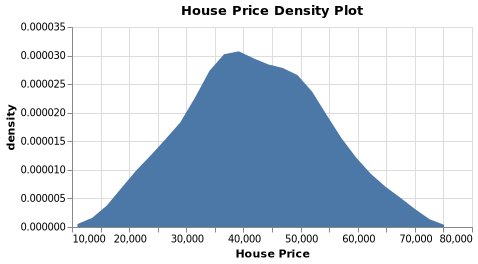

In [4]:
houseprice_dp

Average house prices generally increase with area range, however that trend is broken in the range 80-120 sqft as well as 180-200 sqft. 

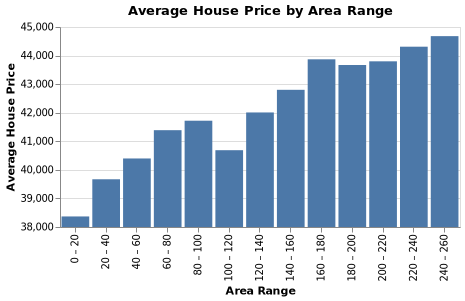

In [5]:
ahp 

Having white marble type and a fiber connection tends to be a strong predictor of price. Variables like Garage, FirePlace, Baths and Floors which increase with Area also tend to predict higher prices. Non predictors of price seem to includes features like Solar SwimmingPool and Garden.

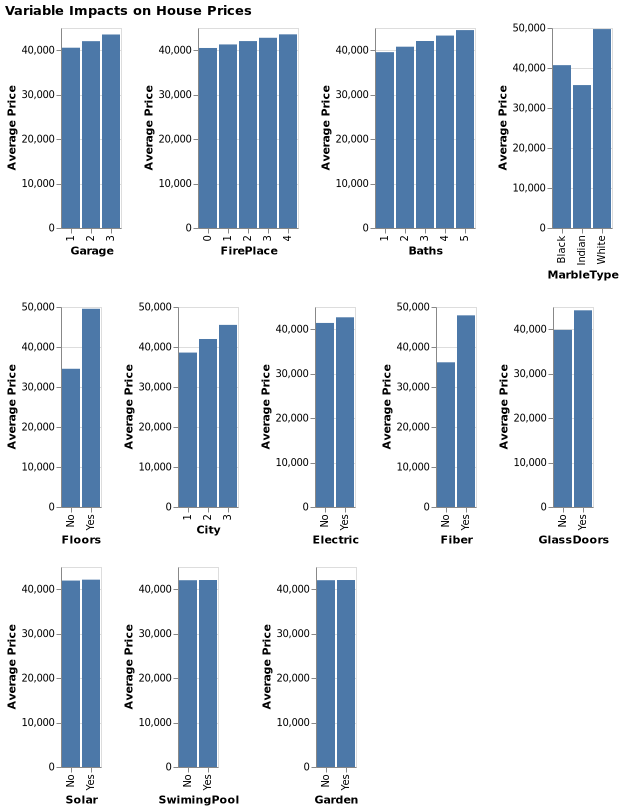

In [6]:
@vlplot(title="Variable Impacts on House Prices") + 
[[Garage FirePlace Baths MarbleType] ; [Floors City Electric Fiber GlassDoors] ; [Solar SwimingPool Garden]] 


## Model Building
The data was split into a training and testing set (70/30).  The data science pipeline requires converting variables into a continuous type, then fitting a EvoTree Regressor model to predict house prices, using a max_dept of 8.  


In [7]:
# Filter data for useful variables and convert Prices to float
houseprice_mod = houseprice |>@select(-:Solar, -:SwimingPool, -:Garden) |> @mutate(Prices = float(_.Prices)) |> DataFrame;

# Select X and y for modeling
X = houseprice_mod |> @select(-:Prices) |> DataFrame
y = houseprice_mod.Prices

# Create an index for model and validation sets
m, v = partition(eachindex(y), 0.7, shuffle=true);

# Create model/training sets
Xm = X[m,:]
ym = y[m]

# Create validation/testing sets
Xv = X[v,:]
yv = y[v]

# load EvoTreeRegressor model
Tree = @load EvoTreeRegressor pkg="EvoTrees"

# Create pipeline that converts inputs into continous and fits an EvoTreeRegressor
pipe = @pipeline(
X -> coerce(X, Count => Continuous),
Tree(max_depth = 8),
prediction_type=:deterministic
);

# Fit machine
mach = machine(pipe, Xm, ym);
fit!(mach);

pipe

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/chigball/.julia/packages/MLJModels/9mQfs/src/loading.jl:168
┌ Info: Training Machine{Pipeline357,…} @615.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Training Machine{EvoTreeRegressor{Float64,…},…} @168.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342


import EvoTrees ✔


Pipeline357(
    evo_tree_regressor = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 8,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(444, (0, 3500988, 3499986, 134)),
            device = "cpu")) @167

## Cross Validation

The number of rounds of training (nrounds) was plotted on a learning curve.  After about 120 rounds there are diminishing returns for a low rms error, as a result the original model will be retrained with nrounds=128 rather than nrounds=10.  

In [8]:
# Function to plot learning curves
function plot_lc(curve::NamedTuple, measure::String)
  
  # Create a dataframe from data
  df = DataFrame(parameter_values = curve.parameter_values, measurements = curve.measurements)
  
  # Use vlplot to plot data  
  @vlplot(
    data = df,
    mark = {:line, tooltip = true, point = true},
    x = {"parameter_values:q", title = curve.parameter_name},
    y = {"measurements:q", title = measure},
    title = "Learning Curve",
    height = 250,
    width = 260
  )  
end

# Generate learning curve
r = range(pipe, :(evo_tree_regressor.nrounds); values = 1:20:130)
curve = learning_curve(mach; range=r, resampling = Holdout(), measure = rms)
mach


┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…} @126.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:342
┌ Info: Attempting to evaluate 7 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/rh0Y9/src/tuned_models.jl:564
Evaluating over 7 metamodels: 100%[=========================] Time: 0:00:34


Machine{Pipeline357,…} @615 trained 1 time; caches data
  args: 
    1:	Source @810 ⏎ `Table{AbstractVector{Count}}`
    2:	Source @361 ⏎ `AbstractVector{Continuous}`


A sufficient number of rounds is needed to achieve rms > 300, as indicated by the chart below

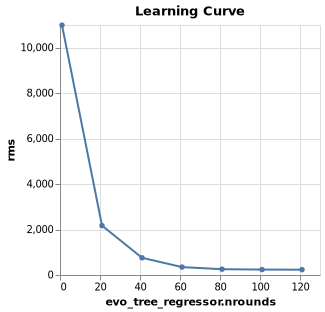

In [9]:
# Plot learning curve
p1 = plot_lc(curve, "rms")

In [10]:
# Retrain model at nrounds = 128
pipe.evo_tree_regressor.nrounds = 128
mach2 = machine(pipe, Xm, ym);
fit!(mach);

┌ Info: Updating Machine{Pipeline357,…} @615.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:343
┌ Info: Updating Machine{EvoTreeRegressor{Float64,…},…} @168.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/gcxd6/src/machines.jl:343


## Model Evaluation 

Evaluation was done using the metrics rms and mae and a 70% shuffled resampling.  An error of <250 as achieved for both metrics.  

In [11]:
# Model Evaluation on test data
yp = collect(predict(mach, Xv))
RMS = round(rms(yp, yv), digits = 3) 
COR = round(corkendall(yp, yv), digits = 3) 

# Model Evaluation
evaluate!(mach2, 
  resampling=Holdout(fraction_train=0.7, shuffle=true, rng=1234),
  measures=[rms, mae],
  verbosity = 0
)


┌───────────────────────────┬───────────────┬────────────┐
│ _.measure                 │ _.measurement │ _.per_fold │
├───────────────────────────┼───────────────┼────────────┤
│ RootMeanSquaredError @999 │ 232.0         │ [232.0]    │
│ MeanAbsoluteError @900    │ 186.0         │ [186.0]    │
└───────────────────────────┴───────────────┴────────────┘
_.per_observation = [missing, missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]
_.train_test_rows = [ … ]


In [12]:
"A rms error of $(RMS) and a corelation of $(COR)  was also achieved for the test set."

"A rms error of 219.598 and a corelation of 0.989  was also achieved for the test set."

## Feature Importance
Feature selection was done using EvoTree's normalized gain by feature. The most important variables are shown below.

In [13]:
# A function to extract the feature importance from a mach object of an evotree classifier
function Importance(mach::Machine)
    df = report(mach).evo_tree_regressor |> DataFrame |>
    @mutate(Feature = first.(_.feature_importances)) |>
    @mutate(Importance = last.(_.feature_importances)) |>
    @mutate(Importance = round.(_.Importance, digits = 2)) |>
    @filter(_.Importance > 0) |> 
    @select(:Feature, :Importance) |> 
    @vlplot(
        x = "Importance:q",
        y = {"Feature:n", sort = "-x"},
        mark = {:bar, tooltops = true},
        height = 300,
        title = "Feature Importance Ranking"    
    )
end;


This chart shows how important variables correlate with house price.  Having more floors along with the presence of fiber optics and white marble relates to higher prices.    

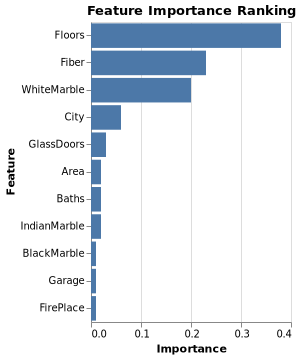

In [14]:
# Plot the feature importance ranking
Importance(mach2)